Dataset shape after processing: (12597, 116)
Optimal number of clusters found: 20


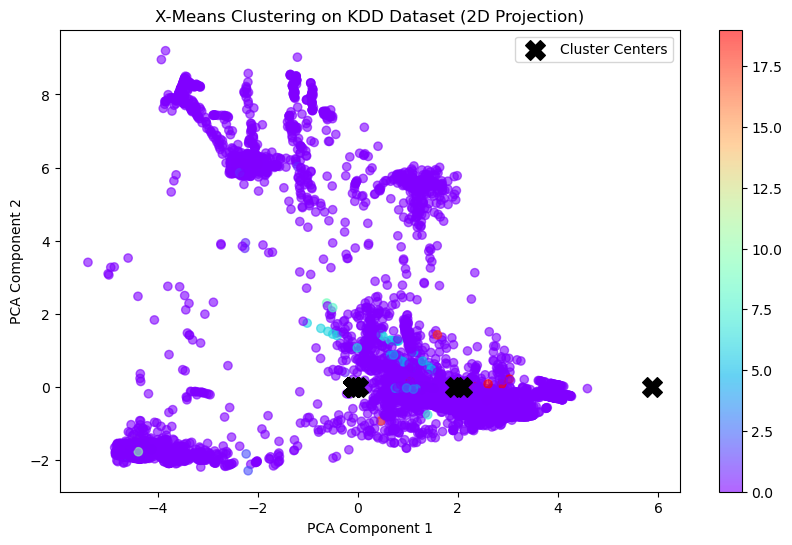

cluster
0.0     12456
1.0        39
3.0        30
5.0        11
11.0       11
4.0        11
6.0        10
10.0        9
19.0        5
15.0        3
13.0        2
2.0         2
9.0         1
12.0        1
17.0        1
14.0        1
16.0        1
7.0         1
8.0         1
18.0        1
Name: count, dtype: int64
Lower Bound 0.9
Upper Bound 86.0
Detected Anomalous Clusters: [0.0]


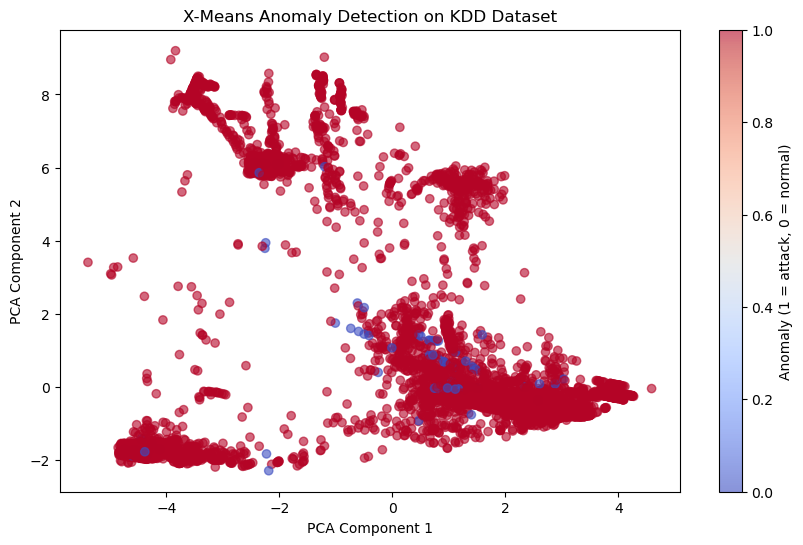

Accuracy: 0.5612
F1 Score: 0.7171
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       994
           1       0.56      1.00      0.72      1260

    accuracy                           0.56      2254
   macro avg       0.78      0.50      0.36      2254
weighted avg       0.75      0.56      0.41      2254



In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
import warnings
np.warnings = warnings

categorical_cols = ['protocol_type', 'service', 'flag']

df = pd.read_csv("../Dataset/KDDTrain+.txt", header=None, sep=',', engine='python')
test_df = pd.read_csv("../Dataset/KDDTest+.txt", header=None, sep=',', engine='python')

# Define all feature names based on NSL-KDD dataset
all_features = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_count',
    'dst_host_diff_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target', 'difficulty'
]

df.columns = all_features
test_df.columns = all_features

df = df.sample(frac=0.1, replace=False)
test_df = test_df.sample(frac=0.1, replace=False)

df['target'] = df['target'].apply(lambda x: 1 if x != 'normal' else 0)
test_df['target'] = test_df['target'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop 'difficulty' column (not needed for model training)
df.drop(columns=['difficulty'], inplace=True)
test_df.drop(columns=['difficulty'], inplace=True)

# One-Hot Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_encoded = encoder.fit_transform(df[categorical_cols])
test_df_encoded = encoder.transform(test_df[categorical_cols])

# Convert encoded features into DataFrame
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(df_encoded, columns=encoded_feature_names)
test_df_encoded = pd.DataFrame(test_df_encoded, columns=encoded_feature_names)

# Drop original categorical columns and concatenate encoded features
df = df.drop(columns=categorical_cols).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, df_encoded], axis=1)
test_df = pd.concat([test_df, test_df_encoded], axis=1)

# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['target']))
test_df_scaled = scaler.transform(test_df.drop(columns=['target']))

print(f"Dataset shape after processing: {df_scaled.shape}")


# Initialize centers
initial_centers = kmeans_plusplus_initializer(df_scaled, 2).initialize()

# Run X-Means Clustering
xmeans_instance = xmeans(df_scaled, initial_centers)
xmeans_instance.process()

# Get cluster results
clusters = xmeans_instance.get_clusters()
final_centers = xmeans_instance.get_centers()

print("Optimal number of clusters found:", len(clusters))

# Create an array to store cluster labels for each data point
cluster_labels = np.zeros(len(df_scaled))  

# Assign each point to its corresponding cluster
for cluster_idx, cluster_points in enumerate(clusters):
    for point_idx in cluster_points:
        cluster_labels[point_idx] = cluster_idx

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Plot Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6)
plt.scatter(np.array(final_centers)[:, 0], np.array(final_centers)[:, 1], c='black', marker='X', s=200, label='Cluster Centers')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Clustering on KDD Dataset (2D Projection)")
plt.legend()
plt.colorbar(scatter)
plt.show()

# Add clusters to original data frame.
df['cluster'] = cluster_labels

# Show distribution of points in each cluster
print(df['cluster'].value_counts())

# Find cluster sizes
cluster_sizes = df['cluster'].value_counts()
Q1 = np.percentile(cluster_sizes, 25)
Q3 = np.percentile(cluster_sizes, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.01 * IQR  # Higer multiplier = Stricter detection
upper_bound = Q3 + 7.5 * IQR  # Can also check large clusters

anomalous_clusters = cluster_sizes[(cluster_sizes < lower_bound) | (cluster_sizes > upper_bound)].index.tolist()

print("Lower Bound", lower_bound)
print("Upper Bound", upper_bound)
print("Detected Anomalous Clusters:", anomalous_clusters)

# Add anomaly column (1 if in an anomalous cluster, else 0)
df['anomaly'] = df['cluster'].apply(lambda x: 1 if x in anomalous_clusters else 0)

# Visualize Anomalies in 2D
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Anomaly Detection on KDD Dataset")
plt.colorbar(label="Anomaly (1 = attack, 0 = normal)")
plt.show()

# Predict clusters for the test data
test_clusters = xmeans_instance.predict(test_df_scaled)

# Assign the cluster labels to the test set
test_df['cluster'] = test_clusters

# Map each cluster to the most common attack/normal label in the test set
cluster_mapping = test_df.groupby('cluster')['target'].agg(lambda x: x.value_counts().idxmax())

# Assign predicted labels
test_df['predicted_label'] = test_df['cluster'].map(cluster_mapping).fillna('unknown')
test_df['predicted_binary'] = test_df['predicted_label'].apply(lambda x: 1 if x != 'normal' else 0) # Convert to binary
test_df = test_df.dropna(subset=['predicted_label'])

# Compute evaluation metrics
accuracy = accuracy_score(test_df['target'], test_df['predicted_label'])
f1 = f1_score(test_df['target'], test_df['predicted_binary'])

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(test_df['target'], test_df['predicted_label'], zero_division=0))